In [2]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
# from IPython import display
# from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive/')
# path = "/content/drive/My Drive/HDSP/PnP-ADMM"
path = "/content/drive/My Drive/DATA"
os.chdir(path)

from os import listdir
from os.path import isfile, join

import numpy as np
import keras
import scipy.io
import pandas as pd
from scipy.io import loadmat

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
tf.random.set_seed(
    1234
)
#---------------------defined function used -------------------------------------------------------------------


# Defined protocol of input and ouput (it is recommended only read, not applied operator here, but it is possible)
def Input_image(image):
    images = loadmat(image).get('y')
    images = np.expand_dims(images,-1)
    # procesamiento
    return images/np.max(images)

def Oput_image(image):
    images = loadmat(image).get('y_m')
    images = np.expand_dims(images, -1)
    return images/np.max(images)

def load_sambles(data):
  data = data[['inimg']]
  inimg_name = list(data.iloc[:,0])
  samples = []
  for samp in inimg_name:
    samples.append(samp)
  return samples


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, samples,PATH,batch_size=1,dim_input=(512, 512, 3), shuffle=True, dim_oput=(512, 512, 3)):
        'Initialization'
        self.dim_input = dim_input
        self.dim_oput = dim_oput
        self.batch_size = batch_size
        self.list_images = samples
        self.shuffle = shuffle
        self.PATH = PATH
        self.on_epoch_end()


    # falta __data_generation
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(len(self.list_images) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        images_name = [self.list_images[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(images_name)

        return X, y

    def on_epoch_end(self):
        'Update indexes after each epoch'
        self.indexes = np.arange(len(self.list_images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, images_names):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim_input))  # Array de numpy con zeros de tamaño
        y = np.empty((self.batch_size, *self.dim_oput))
        # Generate data
        for i, file_name in enumerate(images_names):
            # Store sample
            X[i,] = Input_image(self.PATH + '/' + file_name)
            # Store class
            y[i,] = Oput_image(self.PATH + '/' + file_name)
        return X, y



def Build_data_set(IMG_WIDTH,IMG_HEIGHT,L_bands,L_imput,BATCH_SIZE,PATH,split_v):

  # Random split
  data_dir_list = os.listdir(PATH)
  N = len(data_dir_list)
  train_df = pd.DataFrame(columns=['inimg'])
  test_df = pd.DataFrame(columns=['inimg'])
  randurls = np.copy(data_dir_list)
  train_n = round(N * split_v)
  np.random.shuffle(randurls)
  tr_urls = randurls[:train_n]
  ts_urls = randurls[train_n:N]
  for i in tr_urls:
      train_df = train_df.append({'inimg': i}, ignore_index=True)
  for i in ts_urls:
      test_df = test_df.append({'inimg': i}, ignore_index=True)

  params = {'dim_input': (IMG_WIDTH, IMG_HEIGHT, L_imput),
            'dim_oput': (IMG_WIDTH, IMG_HEIGHT, L_bands),
            'batch_size': BATCH_SIZE,
            'PATH': PATH,
            'shuffle': True}

  partition_Train = load_sambles(test_df)
  partition_Test = load_sambles(train_df)

  train_generator = DataGenerator(partition_Train, **params)
  test_generator = DataGenerator(partition_Test, **params)

  train_dataset = tf.data.Dataset.from_generator(
      lambda: train_generator,
      (tf.float32, tf.float32))

  test_dataset = tf.data.Dataset.from_generator(
      lambda: test_generator,
      (tf.float32, tf.float32))

  return train_dataset,test_dataset

def PSNR_Metric(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true,y_pred,tf.reduce_max(y_true)))

# os.environ["CUDA_VISIBLE_DEVICES"]= '1'
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
# !pwd
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


#----------------------------- directory of the spectral data set -------------------------                              # for windows
BATCH_SIZE = 1; L_bands    = 1; L_imput    = 1;
from scipy.io import loadmat
# from recoverynet import *     # Net build


#########################################################################################

ARAD = False # @ {type:"boolean"} ### IF TRUE MODIFIY NETWORK
if ARAD:
  IMG_WIDTH = 286; IMG_HEIGHT = 256;
  path_files  = os.getcwd()+'/ARAD/Y'
  nI = 10
else:
  IMG_WIDTH = 535; IMG_HEIGHT = 512;
  path_files  = os.getcwd()+'/REAL/Y'
  nI = 14
reTrain = False # @ {type:"boolean"}
gf=0.0  # @ {type:"raw"}
awgn=25 # @ {type:"raw"}
lr = 1e-4# @ {type:"raw"}
batch =  nI# @ {type:"raw"}

norm_inp="NO-F"  # @ {type:"raw"}
norm_out="NO-F"  # @ {type:"raw"}
loss =  'mean_squared_error'# @ {type:"string"}
model_path=os.getcwd()
net = "NO-NO"
old_cp_dir=model_path+'/Weights/Ruben/' #@param {type:"raw"}
# if ARAD:
#     old_cp_dir += 'ARAD_'+str(gf)+'_'+str(awgn)+'_'+net+'/'
# else:
#     old_cp_dir += 'REAL/'




#########################################################################################

optimizad = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=False)

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=new_cp_path,
#     save_weights_only=True,
#     verbose=1,
#     save_freq='epoch',
#     monitor='PSNR_Metric',
#     mode='max',
#     save_best_only=True)



Y_inp = None
for s in range(nI):
  if norm_inp!="" and ARAD:
    Temp = np.array(loadmat(path_files + '/y_ideal_'+str(s+1)+'_'+norm_inp)['y_ideal'])
  else:
    Temp = np.array(loadmat(path_files + '/y_ideal_'+str(s+1))['y_ideal'])
  if Y_inp is None:
    Y_inp = np.expand_dims(Temp, 0)
  else:
    Y_inp = np.concatenate((Y_inp, np.expand_dims(Temp, 0)),0)

Y_oup = None
for s in range(nI):
  if norm_out!="" and ARAD:
    Temp = np.array(loadmat(path_files + '/y_real_m_'+str(s+1)+'_'+str(gf)+'_'+str(awgn)+'_'+norm_out)['y_real_m'])
  elif ARAD:
    Temp = np.array(loadmat(path_files + '/y_real_m_'+str(s+1)+'_'+str(gf)+'_'+str(awgn))['y_real_m'])
  else:
    Temp = np.array(loadmat(path_files + '/y_real_'+str(s+1))['y_real'])
  if Y_oup is None:
    Y_oup = np.expand_dims(Temp, 0)
  else:
    Y_oup = np.concatenate((Y_oup, np.expand_dims(Temp, 0)),0)

Y_inp = np.expand_dims(Y_inp, -1)
Y_oup = np.expand_dims(Y_oup, -1)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Sun Sep 11 15:34:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

#1

In [ ]:
def parches1stride(imagen:np.array) -> np.array:

  imagen = np.pad(imagen.reshape(512,535),pad_width=1) # Add padd
  size = imagen.shape # dims
  parches = [] # 3x3 groups

  for x in range(1,size[0]-1):
    for y in range(1,size[1]-1):
      parche = np.array(imagen[x-1:x+2,y-1:y+2]).reshape(3,3,-1)
      parches.append(parche)

  return np.array(parches)

In [ ]:
#@title Shape 14, 273920, 3, 3
datasetParches = []
datasetPixeles = []

for y,ideal in zip(Y_inp,Y_oup):
  imgParches = parches1stride(y)
  imgPixeles = ideal.reshape(-1)
  datasetParches.append(imgParches)
  datasetPixeles.append(imgPixeles)

datasetParches = np.array(datasetParches)
datasetPixeles = np.array(datasetPixeles)

In [ ]:
#@title 
datasetParches = []
datasetPixeles = []

for y,ideal in zip(Y_inp,Y_oup):
  imgParches = parches1stride(y)
  imgPixeles = ideal.reshape(-1)
  datasetParches.append(imgParches)
  datasetPixeles.append(imgPixeles)

datasetParches = np.array(datasetParches).reshape(-1,3,3,1)
datasetPixeles = np.array(datasetPixeles).reshape(-1)

In [ ]:
print(datasetParches.shape)
print(datasetPixeles.shape)

(14, 273920, 3, 3, 1)
(14, 273920)


In [ ]:
model_in_do_ba = tf.keras.models.Sequential()
model_in_do_ba.add(tf.keras.layers.Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid', input_shape=(3,3,1)))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_in_do_ba.add(tf.keras.layers.Dropout(0.2))
model_in_do_ba.add(tf.keras.layers.Conv2D(64, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.Conv2D(64, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.MaxPooling2D((1, 1)))
model_in_do_ba.add(tf.keras.layers.Dropout(0.2))
model_in_do_ba.add(tf.keras.layers.Flatten())
model_in_do_ba.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_uniform', bias_initializer='he_uniform',  activation='relu'))
model_in_do_ba.add(tf.keras.layers.Dropout(0.2))
model_in_do_ba.add(tf.keras.layers.Dense(1, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_in_do_ba.compile(optimizer=opt, loss='mse',metrics=['accuracy'])

In [ ]:
history = model_in_do_ba.fit(datasetParches, datasetPixeles, epochs=5,verbose=1, batch_size=256)

# Divisiones

In [60]:
def dividirImagen(img:np.array, divOrpix:bool)->np.array:
  
  # Tomamos la solapada 
  img = img[:,31:505]
  img = np.pad(img.reshape(512,474),((5,5), (11,11)), constant_values=0)
  size = img.shape

  divisiones = []
  pixels = []

  divsY = int(img.shape[1]/31)
  divsX = int(img.shape[0]/29)

  for x in range(divsX):
    for y in range(divsY):
      div = img[29*(x):29*(x+1),31*(y):31*(y+1)]
      if divOrpix:
        divisiones.append(div)
      else:
        # divs will be pixels
        divisiones.append(div[14,15])

  return divisiones

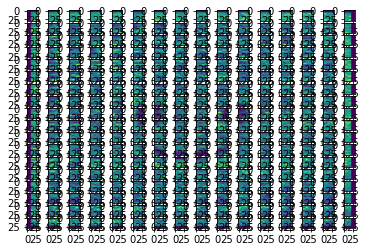

In [61]:
#@title Test divisiones
divs = dividirImagen(Y_inp[0],divOrpix=True)

# plt.figure(figsize=(20,20))
for ind, img in zip(range(288),divs):
  plt.subplot(18,16,ind+1)
  plt.imshow(img.reshape(29,31))

In [ ]:
datasetParches = []
datasetPixeles = []

for y,ideal in zip(Y_inp,Y_oup):

  imgParches = dividirImagen(y,True) # divs from real images
  imgPixeles = dividirImagen(ideal,False) # pixels from ideal images

  datasetParches.append(imgParches)
  datasetPixeles.append(imgPixeles)

datasetParches = np.array(datasetParches)#.reshape(-1,29,31,1)
datasetPixeles = np.array(datasetPixeles)#.reshape(-1)

In [ ]:
datasetParches = datasetParches.reshape(-1,29,31,1)
datasetPixeles = datasetPixeles.reshape(-1)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(datasetParches, datasetPixeles, test_size=0.10, random_state=42)
# X_train = X_train.reshape(-1,29,31,1)
# y_train = y_train.reshape(-1)
# X_test = X_test.reshape(-1,29,31,1)
# y_test = y_test.reshape(-1)

In [55]:
tf.keras.backend.clear_session()

model_in_do_ba = tf.keras.models.Sequential()
model_in_do_ba.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid', input_shape=(29,31,1)))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_in_do_ba.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_in_do_ba.add(tf.keras.layers.Conv2D(4, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.Flatten())
model_in_do_ba.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_uniform', bias_initializer='he_uniform',  activation='relu'))
model_in_do_ba.add(tf.keras.layers.Dropout(0.2))
model_in_do_ba.add(tf.keras.layers.Dense(1, activation='relu'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_in_do_ba.compile(optimizer=opt, loss='mse')

In [ ]:
history = model_in_do_ba.fit(datasetParches, datasetPixeles, epochs=40,verbose=1, batch_size=32)

In [12]:
def parches1stride(img:np.array) -> np.array:

  img = np.pad(img.reshape(512,535),((14,14), (15,15)), constant_values=0)
  size = img.shape

  divisiones = []

  size = img.shape # dims
  parches = []

  for x in range(14,size[0]-14):
    for y in range(15,size[1]-15):
      # parche = np.array(imagen[x-1:x+2,y-1:y+2]).reshape(3,3,-1)
      parche = np.array(img[x-14:x+15,y-15:y+16]).reshape(29,31,1)
      parches.append(parche)
      
  return np.array(parches)

In [13]:
parches = parches1stride(Y_inp[0])

In [15]:
a = model_in_do_ba.predict(parches)

Text(0.5, 1.0, 'Ideal')

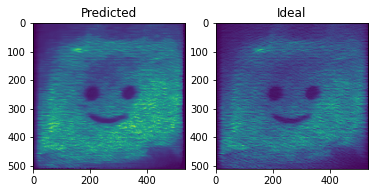

In [16]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(a.reshape(512,535))
plt.title("Predicted")
plt.subplot(1,2,2)
plt.imshow(Y_oup[0].reshape(512,535))
plt.title("Ideal")

In [18]:
PSNR_Metric(Y_oup[0],a.reshape(512,535,1))

<tf.Tensor: shape=(), dtype=float32, numpy=24.040821>

In [40]:
b = model_in_do_ba.predict(parches)

Text(0.5, 1.0, 'Ideal')

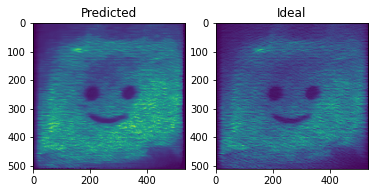

In [41]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(a.reshape(512,535))
plt.title("Predicted")
plt.subplot(1,2,2)
plt.imshow(Y_oup[0].reshape(512,535))
plt.title("Ideal")

In [44]:
PSNR_Metric(Y_oup[0],b.reshape(512,535,1))

<tf.Tensor: shape=(), dtype=float32, numpy=10.567318>

# 1

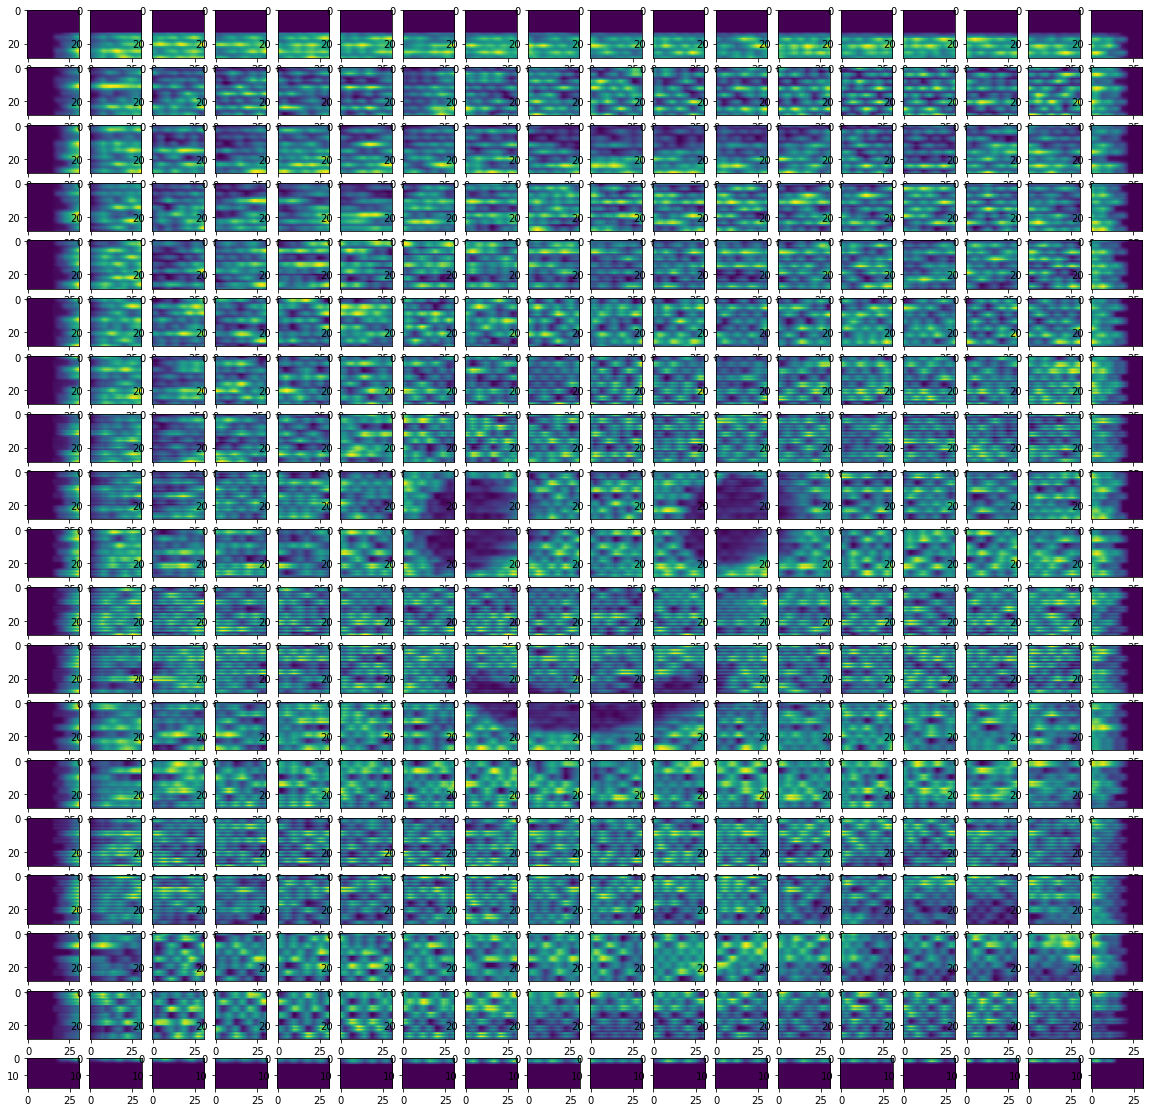

In [113]:
#@title Test divisiones se perdera la ultima fila
divs = dividirImagen(Y_inp[0],divOrpix=True)

plt.figure(figsize=(20,20))
for ind, img in zip(range(len(divs)+1),divs):
  plt.subplot(19,18,ind+1)
  try:
    plt.imshow(img.reshape(29,31))
  except:
    plt.imshow(img.reshape(18,31))

In [114]:
def dividirImagen(img:np.array, divOrpix:bool)->np.array:
  
  # Tomamos toda la imagen
  # img = img[:,31:505]
  img = np.pad(img.reshape(512,535),((14,14), (15,15)), constant_values=0)
  size = img.shape

  divisiones = []
  pixels = []

  divsY = int(img.shape[1]/31)
  divsX = int(img.shape[0]/29)

  for x in range(divsX):
    for y in range(divsY):
      div = img[29*(x):29*(x+1),(31)*(y):(31)*(y+1)]
      if divOrpix:
        divisiones.append(div)
      else:
        # divs will be pixels
        divisiones.append(div[14,15])

  return divisiones

In [115]:
def parches1stride(img:np.array) -> np.array:

  img = np.pad(img.reshape(512,535),((14,14), (15,15)), constant_values=0)
  size = img.shape

  divisiones = []

  size = img.shape # dims
  parches = []

  for x in range(14,size[0]-14):
    for y in range(15,size[1]-15):
      # parche = np.array(imagen[x-1:x+2,y-1:y+2]).reshape(3,3,-1)
      parche = np.array(img[x-14:x+15,y-15:y+16]).reshape(29,31,1)
      parches.append(parche)
      
  return np.array(parches)

In [116]:
datasetParches = []
datasetPixeles = []

for y,ideal in zip(Y_inp,Y_oup):

  imgParches = dividirImagen(y,True) # divs from real images
  imgPixeles = dividirImagen(ideal,False) # pixels from ideal images

  datasetParches.append(imgParches)
  datasetPixeles.append(imgPixeles)

datasetParches = np.array(datasetParches)#.reshape(-1,29,31,1)
datasetPixeles = np.array(datasetPixeles)#.reshape(-1)

In [117]:
datasetParches = datasetParches.reshape(-1,29,31,1)
datasetPixeles = datasetPixeles.reshape(-1)

In [118]:
tf.keras.backend.clear_session()

model_in_do_ba = tf.keras.models.Sequential()
model_in_do_ba.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid', input_shape=(29,31,1)))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_in_do_ba.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.BatchNormalization())
model_in_do_ba.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_in_do_ba.add(tf.keras.layers.Conv2D(4, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_in_do_ba.add(tf.keras.layers.Flatten())
model_in_do_ba.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_uniform', bias_initializer='he_uniform',  activation='relu'))
model_in_do_ba.add(tf.keras.layers.Dropout(0.2))
model_in_do_ba.add(tf.keras.layers.Dense(1, activation='relu'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_in_do_ba.compile(optimizer=opt, loss='mse')

In [119]:
history = model_in_do_ba.fit(datasetParches, datasetPixeles, epochs=40,verbose=1, batch_size=32)

Epoch 1/40
142/142 [==============================] - 1s 5ms/step - loss: 0.0770
Epoch 2/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0382
Epoch 3/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0381
Epoch 4/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0371
Epoch 5/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0362
Epoch 6/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0207
Epoch 7/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 8/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0117
Epoch 9/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0104
Epoch 10/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0093
Epoch 11/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0066
Epoch 12/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 13/40
142/142 [====

<tf.Tensor: shape=(), dtype=float32, numpy=23.572758>

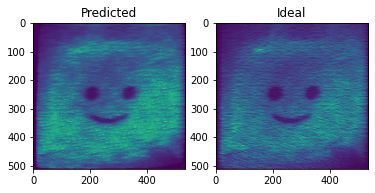

In [120]:
parches = parches1stride(Y_inp[0])
a = model_in_do_ba.predict(parches)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(a.reshape(512,535))
plt.title("Predicted")
plt.subplot(1,2,2)
plt.imshow(Y_oup[0].reshape(512,535))
plt.title("Ideal")

PSNR_Metric(Y_oup[0],a.reshape(512,535,1))

In [127]:
#@title Default title text
tf.keras.backend.clear_session()

model_SGD = tf.keras.models.Sequential()
model_SGD.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid', input_shape=(29,31,1)))
model_SGD.add(tf.keras.layers.BatchNormalization())
model_SGD.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_SGD.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_SGD.add(tf.keras.layers.BatchNormalization())
model_SGD.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_SGD.add(tf.keras.layers.Conv2D(4, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_SGD.add(tf.keras.layers.Flatten())
model_SGD.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_uniform', bias_initializer='he_uniform',  activation='relu'))
model_SGD.add(tf.keras.layers.Dropout(0.2))
model_SGD.add(tf.keras.layers.Dense(1, activation='relu'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_SGD.compile(optimizer=opt, loss='mse')

history = model_SGD.fit(datasetParches, datasetPixeles, epochs=40,verbose=1, batch_size=32)

Epoch 1/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0398
Epoch 2/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0200
Epoch 3/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0109
Epoch 4/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 5/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0079
Epoch 6/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0056
Epoch 7/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 8/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 9/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0035
Epoch 10/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0033
Epoch 11/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0032
Epoch 12/40
142/142 [==============================] - 1s 4ms/step - loss: 0.0031
Epoch 13/40
142/142 [====

<tf.Tensor: shape=(), dtype=float32, numpy=23.219704>

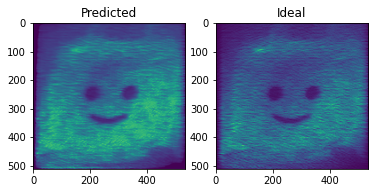

In [128]:
parches = parches1stride(Y_inp[0])
b = model_SGD.predict(parches)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(b.reshape(512,535))
plt.title("Predicted")
plt.subplot(1,2,2)
plt.imshow(Y_oup[0].reshape(512,535))
plt.title("Ideal")

PSNR_Metric(Y_oup[0],b.reshape(512,535,1))

# 2

In [130]:
def dividirImagen(img:np.array, divOrpix:bool)->np.array:
  
  # 
  img = img[:,31:505]
  img = np.pad(img.reshape(512,474),((14,14), (15,15)), constant_values=0)
  size = img.shape

  divisiones = []
  pixels = []

  divsY = int(img.shape[1]/31)
  divsX = int(img.shape[0]/29)

  for x in range(divsX):
    for y in range(divsY):
      div = img[29*(x):29*(x+1),(31)*(y):(31)*(y+1)]
      if divOrpix:
        divisiones.append(div)
      else:
        # divs will be pixels
        divisiones.append(div[14,15])

  return divisiones


def parches1stride(img:np.array) -> np.array:

  img = np.pad(img.reshape(512,535),((14,14), (15,15)), constant_values=0)
  size = img.shape

  divisiones = []

  size = img.shape # dims
  parches = []

  for x in range(14,size[0]-14):
    for y in range(15,size[1]-15):
      # parche = np.array(imagen[x-1:x+2,y-1:y+2]).reshape(3,3,-1)
      parche = np.array(img[x-14:x+15,y-15:y+16]).reshape(29,31,1)
      parches.append(parche)
      
  return np.array(parches)

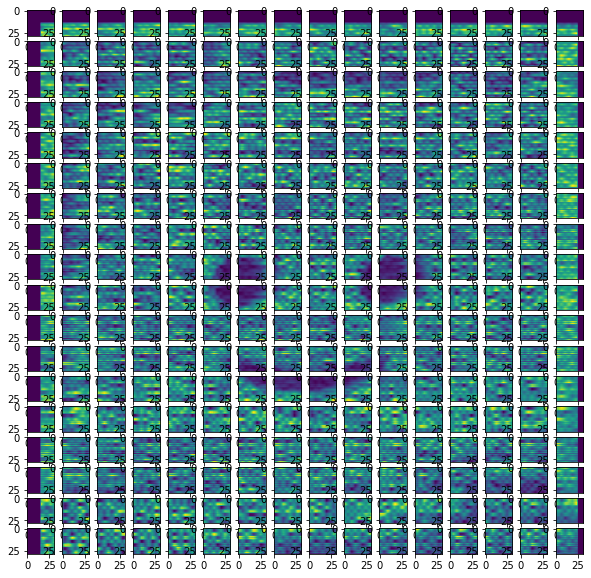

In [135]:
#@title Test divisiones 
divs = dividirImagen(Y_inp[0],divOrpix=True)

plt.figure(figsize=(10,10))
for ind, img in zip(range(len(divs)+1),divs):
  plt.subplot(18,16,ind+1)
  plt.imshow(img.reshape(29,31))

In [143]:
datasetParches = []
datasetPixeles = []

for y,ideal in zip(Y_inp,Y_oup):

  imgParches = dividirImagen(y,True) # divs from real images
  imgPixeles = dividirImagen(ideal,False) # pixels from ideal images

  datasetParches.append(imgParches)
  datasetPixeles.append(imgPixeles)

datasetParches = np.array(datasetParches).reshape(-1,29,31,1)
datasetPixeles = np.array(datasetPixeles).reshape(-1)

In [146]:
#@title Default title text
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid', input_shape=(29,31,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(4, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_uniform', bias_initializer='he_uniform',  activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='relu'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')

history = model.fit(datasetParches, datasetPixeles, epochs=40,verbose=1, batch_size=32)

Epoch 1/40
126/126 [==============================] - 1s 4ms/step - loss: 0.0598
Epoch 2/40
126/126 [==============================] - 0s 4ms/step - loss: 0.0423
Epoch 3/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0391
Epoch 4/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 5/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0341
Epoch 6/40
126/126 [==============================] - 0s 4ms/step - loss: 0.0308
Epoch 7/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 8/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0261
Epoch 9/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 10/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 11/40
126/126 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 12/40
126/126 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 13/40
126/126 [====

<tf.Tensor: shape=(), dtype=float32, numpy=22.141237>

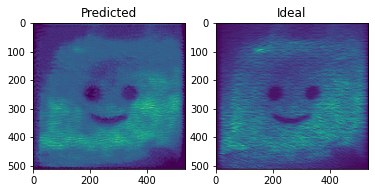

In [147]:
parches = parches1stride(Y_inp[0])
b = model.predict(parches)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(b.reshape(512,535))
plt.title("Predicted")
plt.subplot(1,2,2)
plt.imshow(Y_oup[0].reshape(512,535))
plt.title("Ideal")

PSNR_Metric(Y_oup[0],b.reshape(512,535,1))

In [167]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datasetParches, datasetPixeles, test_size=0.20, random_state=42)
X_train = X_train.reshape(-1,29,31,1)
y_train = y_train.reshape(-1)
# X_test = X_test.reshape(-1,29,31,1)
# y_test = y_test.reshape(-1)

In [149]:
#@title Default title text
tf.keras.backend.clear_session()

model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid', input_shape=(29,31,1)))
model_2.add(tf.keras.layers.BatchNormalization())
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_2.add(tf.keras.layers.BatchNormalization())
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2.add(tf.keras.layers.Conv2D(4, (1,1), activation='relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='valid'))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_uniform', bias_initializer='he_uniform',  activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(1, activation='relu'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(optimizer=opt, loss='mse')

history = model_2.fit(X_train, y_train, epochs=40,verbose=1, batch_size=32)

Epoch 1/40
101/101 [==============================] - 1s 5ms/step - loss: 0.1811
Epoch 2/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0545
Epoch 3/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0442
Epoch 4/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0451
Epoch 5/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0444
Epoch 6/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0431
Epoch 7/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0432
Epoch 8/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0468
Epoch 9/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0443
Epoch 10/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0431
Epoch 11/40
101/101 [==============================] - 0s 4ms/step - loss: 0.0430
Epoch 12/40
101/101 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 13/40
101/101 [====

In [ ]:
parches = parches1stride(Y_oup[10])
b = model_2.predict(parches)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(b.reshape(512,535))
plt.title("Predicted")
plt.subplot(1,2,2)
plt.imshow(Y_oup[10].reshape(512,535))
plt.title("Ideal")

PSNR_Metric(Y_oup[10],b.reshape(512,535,1))